In [ ]:
import math
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## TF

In [ ]:
(ds_train, ds_test) = tfds.load('mnist', split=['train', 'test'],as_supervised=True)

In [ ]:
ex = iter(ds_train)
image, label = next(ex)
image.shape

TensorShape([28, 28, 1])

In [ ]:
ds_train = ds_train.map(lambda img, lbl: (tf.cast(img, tf.float32)/255., label),
                        num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(lambda img, lbl: (tf.cast(img, tf.float32)/255., label),
                        num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

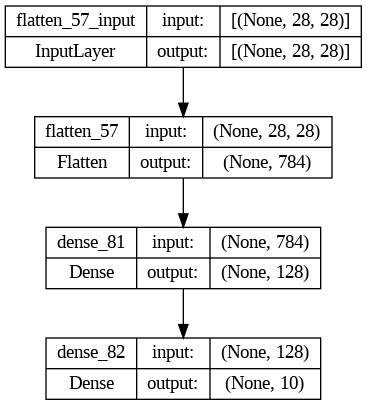

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
model.fit(ds_train, epochs=5, validation_data=ds_test)

Epoch 1/5
469/469 [==============================] - 12s 25ms/step - loss: 0.0160 - acc: 0.9977 - val_loss: 9.5369e-07 - val_acc: 1.0000
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 9.5368e-07 - acc: 1.0000 - val_loss: 9.5369e-07 - val_acc: 1.0000
Epoch 3/5
469/469 [==============================] - 7s 14ms/step - loss: 9.5368e-07 - acc: 1.0000 - val_loss: 9.5369e-07 - val_acc: 1.0000
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 9.5368e-07 - acc: 1.0000 - val_loss: 9.5369e-07 - val_acc: 1.0000
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 9.5368e-07 - acc: 1.0000 - val_loss: 9.5369e-07 - val_acc: 1.0000


Functional model with custom activation

<p align="center">
$
    activation(x)=
\begin{cases}
    0, & \text{if } x < 0\\
    sin(x-\frac{\pi}{2})+1, & \text{if } 0 \leq x \leq \frac{\pi}{2}\\
    x - \frac{\pi}{2} + 1, & \text{otherwise}
\end{cases}
$
</p>

In [ ]:
@tf.function
def activation_function(x):
    return tf.where(tf.less(x, 0), tf.zeros_like(x),
                    tf.where(tf.logical_and(tf.greater_equal(x, 0),
                                            tf.less_equal(x, math.pi/2)),
                             tf.sin(x-math.pi/2) + 1,
                             x - (math.pi/2) + 1
                             )
                    )

In [ ]:
input = tf.keras.layers.Input(shape=(28,28))
flat = tf.keras.layers.Flatten()(input)
h = tf.keras.layers.Dense(128)(flat)
activation = tf.keras.layers.Lambda(activation_function)(h)
output = tf.keras.layers.Dense(10)(activation)

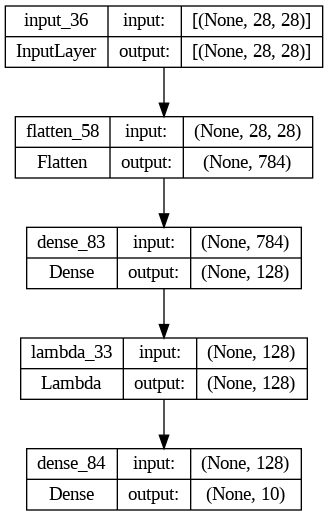

In [ ]:
model_func = tf.keras.models.Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model_func, show_shapes=True)

In [ ]:
model_func.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
model_func.fit(ds_train, epochs=5, validation_data=ds_test)

Epoch 1/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0349 - acc: 0.9967 - val_loss: 9.9351e-07 - val_acc: 1.0000
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 1.0420e-06 - acc: 1.0000 - val_loss: 1.8068e-06 - val_acc: 1.0000
Epoch 3/5
469/469 [==============================] - 6s 12ms/step - loss: 9.9279e-07 - acc: 1.0000 - val_loss: 1.8028e-06 - val_acc: 1.0000
Epoch 4/5
469/469 [==============================] - 4s 10ms/step - loss: 9.9279e-07 - acc: 1.0000 - val_loss: 1.7972e-06 - val_acc: 1.0000
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 9.9276e-07 - acc: 1.0000 - val_loss: 1.7899e-06 - val_acc: 1.0000


## Torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
class NormalizeBy255(object):
    def __call__(self, sample):
        return sample / 255.0

transform = transforms.Compose([
    transforms.ToTensor(),
    NormalizeBy255()
])

In [ ]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
num_epochs = 15
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = inputs.view(inputs.size(0), -1)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

[Epoch 1] loss: 1.564
[Epoch 2] loss: 0.698
[Epoch 3] loss: 0.495
[Epoch 4] loss: 0.414
[Epoch 5] loss: 0.372
[Epoch 6] loss: 0.347
[Epoch 7] loss: 0.329
[Epoch 8] loss: 0.315
[Epoch 9] loss: 0.304
[Epoch 10] loss: 0.294
[Epoch 11] loss: 0.286
[Epoch 12] loss: 0.278
[Epoch 13] loss: 0.271
[Epoch 14] loss: 0.264
[Epoch 15] loss: 0.257


Custom activation

In [ ]:
class CustomActivation(nn.Module):
  def forward(self, x):
    return torch.where(x < 0,
                       torch.tensor(0.),
                       torch.where((x >= 0) & (x <= (math.pi/2)),
                                   torch.sin(x - (math.pi/2)) + 1,
                                   x - (math.pi/2) + 1))

In [ ]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    CustomActivation(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
num_epochs = 15
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = inputs.view(inputs.size(0), -1)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

[Epoch 1] loss: 1.747
[Epoch 2] loss: 0.841
[Epoch 3] loss: 0.607
[Epoch 4] loss: 0.503
[Epoch 5] loss: 0.446
[Epoch 6] loss: 0.410
[Epoch 7] loss: 0.386
[Epoch 8] loss: 0.368
[Epoch 9] loss: 0.354
[Epoch 10] loss: 0.343
[Epoch 11] loss: 0.334
[Epoch 12] loss: 0.327
[Epoch 13] loss: 0.320
[Epoch 14] loss: 0.315
[Epoch 15] loss: 0.310
